In [48]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold, train_test_split
from sklearn.grid_search import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [3]:
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 30)

sns.set_style("darkgrid")
sns.set_context(rc={"figure.figsize": (6, 3)})

In [6]:
# load in datasets 
dfs = {}
for name in ['titanic_train', 'titanic_test']:
    df = pd.read_csv('%s.csv' % name)

    # add a column denoting source (train/test)
    df['data'] = name
    
    # add df to dfs dict
    dfs[name] = df

In [8]:
# Check each column info
for name, df in dfs.iteritems():
    print 'df: %s\n' % name
    print 'shape: %d rows, %d cols\n' % df.shape
    
    print 'column info:'
    for col in df.columns:
        print '* %s: %d nulls, %d unique vals, most common: %s' % (
            col, 
            df[col].isnull().sum(),
            df[col].nunique(),
            df[col].value_counts().head(2).to_dict()
        )
    print '\n------\n'

df: titanic_test

shape: 418 rows, 12 cols

column info:
* PassengerId: 0 nulls, 418 unique vals, most common: {1128: 1, 1023: 1}
* Pclass: 0 nulls, 3 unique vals, most common: {1: 107, 3: 218}
* Name: 0 nulls, 418 unique vals, most common: {'Rosenbaum, Miss. Edith Louise': 1, 'Beauchamp, Mr. Henry James': 1}
* Sex: 0 nulls, 2 unique vals, most common: {'male': 266, 'female': 152}
* Age: 86 nulls, 79 unique vals, most common: {24.0: 17, 21.0: 17}
* SibSp: 0 nulls, 7 unique vals, most common: {0: 283, 1: 110}
* Parch: 0 nulls, 8 unique vals, most common: {0: 324, 1: 52}
* Ticket: 0 nulls, 363 unique vals, most common: {'PC 17608': 5, '113503': 4}
* Fare: 1 nulls, 169 unique vals, most common: {7.75: 21, 26.0: 19}
* Cabin: 327 nulls, 76 unique vals, most common: {'B57 B59 B63 B66': 3, 'C101': 2}
* Embarked: 0 nulls, 3 unique vals, most common: {'S': 270, 'C': 102}
* data: 0 nulls, 1 unique vals, most common: {'titanic_test': 418}

------

df: titanic_train

shape: 891 rows, 13 cols

colu

In [26]:
# combine train and test data into one df 
df = dfs['titanic_train'].append(dfs['titanic_test'])

df.columns = map(str.lower, df.columns) # lowercase column names

new_col_order = ['data', 'passengerid', 'survived', 'age',
                'cabin', 'embarked', 'fare', 'name', 'parch',
                'pclass', 'sex', 'sibsp', 'ticket']
df = df[new_col_order] # reorder columns

In [18]:
# Preview new df
df.head(10)

,data,passengerid,survived,age,cabin,embarked,fare,name,parch,pclass,sex,sibsp,ticket
0,titanic_train,1,0.0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,A/5 21171
1,titanic_train,2,1.0,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,PC 17599
2,titanic_train,3,1.0,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,STON/O2. 3101282
3,titanic_train,4,1.0,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,113803
4,titanic_train,5,0.0,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,373450
5,titanic_train,6,0.0,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,3,male,0,330877
6,titanic_train,7,0.0,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,1,male,0,17463
7,titanic_train,8,0.0,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,3,male,3,349909
8,titanic_train,9,1.0,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,3,female,0,347742
9,titanic_train,10,1.0,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,2,female,1,237736


In [27]:
# Data manipulation 
# age 
# fill missing age with mean by data
age_by_data = df.groupby('data')['age'].agg(np.mean).to_dict()
df['age'] = df.apply(lambda row: age_by_data.get(row['data']) 
                     if pd.isnull(row['age']) else row['age'], axis=1)

In [28]:
# Check no na values
df['age'].isnull().sum()

0

In [29]:
# Cabin (There are too many null values, drop this variable)
df['cabin'].isnull().sum()
df= df.drop(['cabin'],axis=1)

In [30]:
df.head()

,data,passengerid,survived,age,embarked,fare,name,parch,pclass,sex,sibsp,ticket
0,titanic_train,1,0.0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,A/5 21171
1,titanic_train,2,1.0,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,PC 17599
2,titanic_train,3,1.0,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,STON/O2. 3101282
3,titanic_train,4,1.0,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,113803
4,titanic_train,5,0.0,35.0,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,373450


In [31]:
# Fill missing embarked with most common port, then drop this unnessary varaible
most_common_port = df['embarked'].mode()[0]
df['embarked'] = df['embarked'].fillna(most_common_port)
df= df.drop(['embarked'],axis=1)
df.head(10)

,data,passengerid,survived,age,fare,name,parch,pclass,sex,sibsp,ticket
0,titanic_train,1,0.0,22.000000,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,A/5 21171
1,titanic_train,2,1.0,38.000000,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,PC 17599
2,titanic_train,3,1.0,26.000000,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,STON/O2. 3101282
3,titanic_train,4,1.0,35.000000,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,113803
4,titanic_train,5,0.0,35.000000,8.0500,"Allen, Mr. William Henry",0,3,male,0,373450
5,titanic_train,6,0.0,29.699118,8.4583,"Moran, Mr. James",0,3,male,0,330877
6,titanic_train,7,0.0,54.000000,51.8625,"McCarthy, Mr. Timothy J",0,1,male,0,17463
7,titanic_train,8,0.0,2.000000,21.0750,"Palsson, Master. Gosta Leonard",1,3,male,3,349909
8,titanic_train,9,1.0,27.000000,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,3,female,0,347742
9,titanic_train,10,1.0,14.000000,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,2,female,1,237736


In [33]:
# Fill missing fare with median by pclass
fare_by_pclass = df[df['fare'] > 0].groupby('pclass')['fare'].agg(np.median).to_dict()
df['fare'] = df.apply(lambda row: row['fare'] if row['fare'] > 0 
                      else fare_by_pclass.get(row['pclass']), axis=1)
df['fare'].isnull().sum()

0

In [34]:
# name column is unnecessary, drop it 
df= df.drop(['name'],axis=1)
df.head(10)

,data,passengerid,survived,age,fare,parch,pclass,sex,sibsp,ticket
0,titanic_train,1,0.0,22.000000,7.2500,0,3,male,1,A/5 21171
1,titanic_train,2,1.0,38.000000,71.2833,0,1,female,1,PC 17599
2,titanic_train,3,1.0,26.000000,7.9250,0,3,female,0,STON/O2. 3101282
3,titanic_train,4,1.0,35.000000,53.1000,0,1,female,1,113803
4,titanic_train,5,0.0,35.000000,8.0500,0,3,male,0,373450
5,titanic_train,6,0.0,29.699118,8.4583,0,3,male,0,330877
6,titanic_train,7,0.0,54.000000,51.8625,0,1,male,0,17463
7,titanic_train,8,0.0,2.000000,21.0750,1,3,male,3,349909
8,titanic_train,9,1.0,27.000000,11.1333,2,3,female,0,347742
9,titanic_train,10,1.0,14.000000,30.0708,0,2,female,1,237736


In [35]:
# Combine parch & sibsp as one column: family
df['family'] =  df["parch"] + df["sibsp"]
df['family'].loc[df['family'] > 0] = 1
df['family'].loc[df['family'] == 0] = 0

D:\Program Files (x86)\ANACONDA\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [36]:
# drop Parch & SibSp
df= df.drop(['parch','sibsp'], axis=1)
df.head(10)

,data,passengerid,survived,age,fare,pclass,sex,ticket,family
0,titanic_train,1,0.0,22.000000,7.2500,3,male,A/5 21171,1
1,titanic_train,2,1.0,38.000000,71.2833,1,female,PC 17599,1
2,titanic_train,3,1.0,26.000000,7.9250,3,female,STON/O2. 3101282,0
3,titanic_train,4,1.0,35.000000,53.1000,1,female,113803,1
4,titanic_train,5,0.0,35.000000,8.0500,3,male,373450,0
5,titanic_train,6,0.0,29.699118,8.4583,3,male,330877,0
6,titanic_train,7,0.0,54.000000,51.8625,1,male,17463,0
7,titanic_train,8,0.0,2.000000,21.0750,3,male,349909,1
8,titanic_train,9,1.0,27.000000,11.1333,3,female,347742,1
9,titanic_train,10,1.0,14.000000,30.0708,2,female,237736,1


In [37]:
# Sex: change to 'Person' by adding one category 'child', whose age <16
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex

df['person'] = df[['age','sex']].apply(get_person,axis=1)
df.head(20)

,data,passengerid,survived,age,fare,pclass,sex,ticket,family,person
0,titanic_train,1,0.0,22.000000,7.2500,3,male,A/5 21171,1,male
1,titanic_train,2,1.0,38.000000,71.2833,1,female,PC 17599,1,female
2,titanic_train,3,1.0,26.000000,7.9250,3,female,STON/O2. 3101282,0,female
3,titanic_train,4,1.0,35.000000,53.1000,1,female,113803,1,female
4,titanic_train,5,0.0,35.000000,8.0500,3,male,373450,0,male
5,titanic_train,6,0.0,29.699118,8.4583,3,male,330877,0,male
6,titanic_train,7,0.0,54.000000,51.8625,1,male,17463,0,male
7,titanic_train,8,0.0,2.000000,21.0750,3,male,349909,1,child
8,titanic_train,9,1.0,27.000000,11.1333,3,female,347742,1,female
9,titanic_train,10,1.0,14.000000,30.0708,2,female,237736,1,child


In [38]:
# drop unnecessary variale ticket & sex
df= df.drop(['ticket','sex'], axis=1)
df.head(10)

,data,passengerid,survived,age,fare,pclass,family,person
0,titanic_train,1,0.0,22.000000,7.2500,3,1,male
1,titanic_train,2,1.0,38.000000,71.2833,1,1,female
2,titanic_train,3,1.0,26.000000,7.9250,3,0,female
3,titanic_train,4,1.0,35.000000,53.1000,1,1,female
4,titanic_train,5,0.0,35.000000,8.0500,3,0,male
5,titanic_train,6,0.0,29.699118,8.4583,3,0,male
6,titanic_train,7,0.0,54.000000,51.8625,1,0,male
7,titanic_train,8,0.0,2.000000,21.0750,3,1,child
8,titanic_train,9,1.0,27.000000,11.1333,3,1,female
9,titanic_train,10,1.0,14.000000,30.0708,2,1,child


In [39]:
# Create new DataFrames for the Categorical Variables
pclass_dummies = pd.get_dummies(df['pclass'])
person_dummies = pd.get_dummies(df['person'])

In [40]:
person_dummies.head(20)

,child,female,male
0,0.0,0.0,1.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,0.0,1.0
5,0.0,0.0,1.0
6,0.0,0.0,1.0
7,1.0,0.0,0.0
8,0.0,1.0,0.0
9,1.0,0.0,0.0


In [41]:
# Create column names for the new dataframes
pclass_dummies.columns = ['pclass1','pclass2','pclass3']
person_dummies.columns = ['child','female','male']

In [42]:
# Concat the dummy DataFrames Together
dummies = pd.concat([pclass_dummies,person_dummies],axis=1)
dummies.head()

,pclass1,pclass2,pclass3,child,female,male
0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0


In [43]:
# Concat the X DataFrame with the dummy variables
df=pd.concat([df, dummies],axis=1)
df.head(10)

,data,passengerid,survived,age,fare,pclass,family,person,pclass1,pclass2,pclass3,child,female,male
0,titanic_train,1,0.0,22.000000,7.2500,3,1,male,0.0,0.0,1.0,0.0,0.0,1.0
1,titanic_train,2,1.0,38.000000,71.2833,1,1,female,1.0,0.0,0.0,0.0,1.0,0.0
2,titanic_train,3,1.0,26.000000,7.9250,3,0,female,0.0,0.0,1.0,0.0,1.0,0.0
3,titanic_train,4,1.0,35.000000,53.1000,1,1,female,1.0,0.0,0.0,0.0,1.0,0.0
4,titanic_train,5,0.0,35.000000,8.0500,3,0,male,0.0,0.0,1.0,0.0,0.0,1.0
5,titanic_train,6,0.0,29.699118,8.4583,3,0,male,0.0,0.0,1.0,0.0,0.0,1.0
6,titanic_train,7,0.0,54.000000,51.8625,1,0,male,1.0,0.0,0.0,0.0,0.0,1.0
7,titanic_train,8,0.0,2.000000,21.0750,3,1,child,0.0,0.0,1.0,1.0,0.0,0.0
8,titanic_train,9,1.0,27.000000,11.1333,3,1,female,0.0,0.0,1.0,0.0,1.0,0.0
9,titanic_train,10,1.0,14.000000,30.0708,2,1,child,0.0,1.0,0.0,1.0,0.0,0.0


In [44]:
# drop unnecessary variables
df= df.drop(['pclass','person'], axis=1)
df.head(10)

,data,passengerid,survived,age,fare,family,pclass1,pclass2,pclass3,child,female,male
0,titanic_train,1,0.0,22.000000,7.2500,1,0.0,0.0,1.0,0.0,0.0,1.0
1,titanic_train,2,1.0,38.000000,71.2833,1,1.0,0.0,0.0,0.0,1.0,0.0
2,titanic_train,3,1.0,26.000000,7.9250,0,0.0,0.0,1.0,0.0,1.0,0.0
3,titanic_train,4,1.0,35.000000,53.1000,1,1.0,0.0,0.0,0.0,1.0,0.0
4,titanic_train,5,0.0,35.000000,8.0500,0,0.0,0.0,1.0,0.0,0.0,1.0
5,titanic_train,6,0.0,29.699118,8.4583,0,0.0,0.0,1.0,0.0,0.0,1.0
6,titanic_train,7,0.0,54.000000,51.8625,0,1.0,0.0,0.0,0.0,0.0,1.0
7,titanic_train,8,0.0,2.000000,21.0750,1,0.0,0.0,1.0,1.0,0.0,0.0
8,titanic_train,9,1.0,27.000000,11.1333,1,0.0,0.0,1.0,0.0,1.0,0.0
9,titanic_train,10,1.0,14.000000,30.0708,1,0.0,1.0,0.0,1.0,0.0,0.0


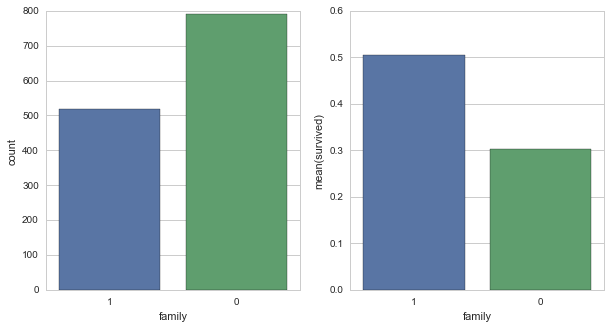

In [50]:
# plot
fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(10,5))

# sns.factorplot('Family',data=titanic_df,kind='count',ax=axis1)
sns.countplot(x='family', data=df, order=[1,0], ax=axis1)

# average of survived for those who had/didn't have any family member
family_perc = df[["family", "survived"]].groupby(['family'],as_index=False).mean()
sns.barplot(x='family', y='survived', data=family_perc, order=[1,0], ax=axis2)


In [53]:
# Prepare train and test data
df_train = df[df['data'] == 'titanic_train']
df_test = df[df['data'] == 'titanic_test']

In [54]:
# Preview
df_train.head()

,data,passengerid,survived,age,fare,family,pclass1,pclass2,pclass3,child,female,male
0,titanic_train,1,0.0,22.0,7.2500,1,0.0,0.0,1.0,0.0,0.0,1.0
1,titanic_train,2,1.0,38.0,71.2833,1,1.0,0.0,0.0,0.0,1.0,0.0
2,titanic_train,3,1.0,26.0,7.9250,0,0.0,0.0,1.0,0.0,1.0,0.0
3,titanic_train,4,1.0,35.0,53.1000,1,1.0,0.0,0.0,0.0,1.0,0.0
4,titanic_train,5,0.0,35.0,8.0500,0,0.0,0.0,1.0,0.0,0.0,1.0


In [55]:
# Preview
df_test.head()

,data,passengerid,survived,age,fare,family,pclass1,pclass2,pclass3,child,female,male
0,titanic_test,892,NaN,34.5,7.8292,0,0.0,0.0,1.0,0.0,0.0,1.0
1,titanic_test,893,NaN,47.0,7.0000,1,0.0,0.0,1.0,0.0,1.0,0.0
2,titanic_test,894,NaN,62.0,9.6875,0,0.0,1.0,0.0,0.0,0.0,1.0
3,titanic_test,895,NaN,27.0,8.6625,0,0.0,0.0,1.0,0.0,0.0,1.0
4,titanic_test,896,NaN,22.0,12.2875,1,0.0,0.0,1.0,0.0,1.0,0.0


In [64]:
# set X,Y for training data
X_train = df_train.drop(['data','passengerid','survived','pclass3','male'],axis=1)
Y_train = df_train['survived']

# Set X for test data
X_test = df_test.drop(['data','passengerid','survived','pclass3','male'],axis=1)

In [65]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
accuracy = logreg.score(X_train, Y_train)
print 'accuracy: %f' % accuracy

accuracy: 0.804714


In [66]:
# Support Vector Machines
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
accuracy=svc.score(X_train, Y_train)
print 'accuracy: %f' % accuracy

accuracy: 0.863075


In [69]:
# Random Forests

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
accuracy=random_forest.score(X_train, Y_train)
print 'accuracy: %f' % accuracy

accuracy: 0.982043


In [68]:
# KNN 
#knn = KNeighborsClassifier(n_neighbors = 3)
#knn.fit(X_train, Y_train)
#Y_pred = knn.predict(X_test)
#accuracy=knn.score(X_train, Y_train)
#print 'accuracy: %f' % accuracy

accuracy: 0.838384


In [72]:
submission = pd.DataFrame({
        "passengerid": df_test["passengerid"],
        "survived": Y_pred
    })
submission.to_csv('titanic_prediction.csv', index=False)